# Constructing Color – Absolute Magnitude Diagrams for Three Star Clusters
## Elliot Cantor

In [2]:
import os, sys
import numpy as np
import pandas as pd
import scipy.optimize
import matplotlib.pyplot as plt
%matplotlib inline
import astropy
from astropy.io.votable import parse
from astroquery.utils.tap.core import TapPlus
#import mpld3
#mpld3.enable_notebook()

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 6]

#Constants in MKS
mSun     = 1.989 * (10**30)      #sun mass
mJup     = 1.898 * (10**27)      #jupiter mass
mEarth   = 5.972 * (10**24)      #earth mass
rSun     = 695.508 * (10**6)     #sun radius
rJup     = 69.911 * (10**6)      #jupiter radius
rEarth   = 6378000               #earth radius
rNep     = (49528 / 2) * (10**3) #neptune radius
AU       = 1.496 * (10**11)      #au
G        = 6.67 * 10**(-11)      #gravitational constant
SB       = 5.67 * (10**-8)       #stephen-boltzman constant
insEarth = 1362                  #insolation flux of earth

rnd      = np.random.RandomState(42)

## Data Retrieval - Hyades

In [3]:
hyadesDist = 47.62 #pc
cutMin = 1000 / (hyadesDist - 15)
cutMax = 1000 / (hyadesDist + 15)
print(f'{cutMax} to {cutMin} mas')

15.969338869370809 to 30.65603923973023 mas


In [4]:
gaia = TapPlus(url="http://gea.esac.esa.int/tap-server/tap")
job = gaia.launch_job_async('''SELECT ALL source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,visibility_periods_used,phot_g_mean_mag,bp_rp,radial_velocity,radial_velocity_error,phot_variable_flag,teff_val,a_g_val, pmra, pmdec 
                                 FROM gaiadr2.gaia_source 
                                WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS',COORD1(EPOCH_PROP_POS(66.725,15.86667,0,104.9200,-28.0000,39.1000,2000,2015.5)),COORD2(EPOCH_PROP_POS(66.725,15.86667,0,104.9200,-28.0000,39.1000,2000,2015.5)),2.5))=1  
                                  AND  (visibility_periods_used>8 AND astrometric_excess_noise<1 
                                  AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2) 
                                  AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2) 
                                  AND parallax_over_error>10 AND phot_g_mean_flux_over_error>50 
                                  AND phot_rp_mean_flux_over_error>20 AND phot_bp_mean_flux_over_error>20 
                                  AND parallax>15.969 AND parallax<30.656 AND sqrt(power(pmra,2) + power(pmdec,2))<111.906 AND sqrt(power(pmra,2) + power(pmdec,2))>101.227)''', dump_to_file=True, output_file = 'hyades.vot')

r = job.get_results()

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


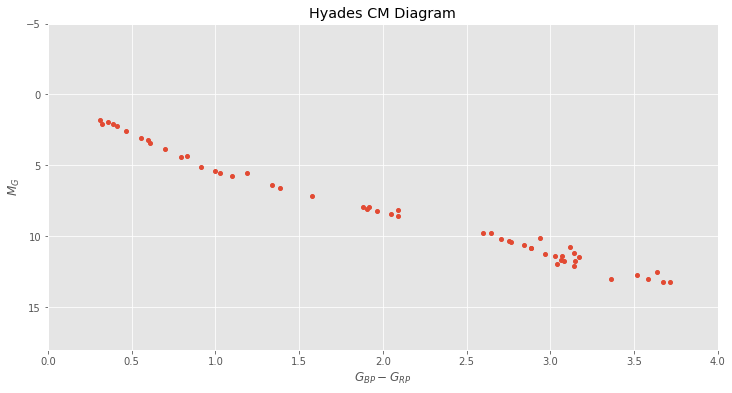

54 stars


In [5]:
xcut  = r['bp_rp']
aparG = r['phot_g_mean_mag']
para  = abs(r['parallax']) / 1000
dist  = 1 / para #pc
absG  = aparG - 5 * np.log10(dist/10)

plt.plot(xcut, absG, '.', markersize = 8)
plt.title('Hyades CM Diagram')
plt.xlabel('$G_{BP} - G_{RP}$')
plt.ylabel('$M_G$')
plt.xlim(0, 4)
plt.ylim(18, -5)
plt.show()

print(len(aparG), 'stars')

### Commenting on the problems that lead to bad astrometry and how the cuts I implemented remove suspect objects:

Some of the problems that can lead to bad astrometry in this data is choosing too small of too wide of a position cut than can exclude much of the cluster targets, or include too many targets outside of the cluster that can hide and in-cluster targets. I tried to find a middle ground with my circular position cut to avoid these issues. Another issue in the astrometry that can arise is that although the there are targets in the same position as desired cluster in RA/DEC phase space, they could be very far away or close, compared to the cluster. This nessecitates the use of a parralax cut to get rid of these targets. I created a sphere of radius 15 parsecs around the distance Hyades is away from Earth is order to cut out bad targets. I translated these bounderies into parallax angles in order to add them to the queries. At large distances away from Earth (>250 pc) parallax and proper motion data degrades significantly, causing me to increase the radius for the sphere that I model around the cluster in oder to account for these larger error bars. I also cut my astrometric noise in order to only select more clear targets inside clusters. If you don't have a decent amount of seperate observations of targets the astrometry data can be very poor, which is why I created a cut that goes by visibility periods used, or the number of groups of observations separated from other groups by a gap of at least four days. Proper motion data from the targets can be a great indicator at finding clusters and isolating those targets in the clusters, as you can look at targets in the sky and determine whether they are moving in a way that is similar to the movements of other targets in the cluster. Thus, proper motion cuts are a nessecity to rid the data stars that may be near the cluster, but are not physically associated with it.

## Cut Phase Space Analysis - Proper Motion
 
<b>Methodology:</b> I caluclate the magnitude of the total proper motion of each target by squaring the RA and DEC proper motion values, adding them together, and square rooting the sum. I then make the proper motion cuts by cutting out targets that have proper motion magnitudes outside of the 2nd and 3rd quartiles. After applying the proper motion cuts, ost of the remaining targets outside the now visible cluster are dealt with through parallax, photometric noise, and astrometric noise cuts. I have included plots of the proper motion phase space without any cuts aside from the position of Hyades, along with a plot of the proper motion phase space with only position and parallax cuts, then a plot of the proper motion phase space with only the proper motion and parallax cuts, and finally a plot of the proper motion phase space with every cut I used.  

In [6]:
gaia = TapPlus(url="http://gea.esac.esa.int/tap-server/tap")
job = gaia.launch_job_async('''SELECT ALL source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,visibility_periods_used,phot_g_mean_mag,bp_rp,radial_velocity,radial_velocity_error,phot_variable_flag,teff_val,a_g_val, pmra, pmdec 
                                 FROM gaiadr2.gaia_source 
                                WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS',COORD1(EPOCH_PROP_POS(66.725,15.86667,0,104.9200,-28.0000,39.1000,2000,2015.5)),COORD2(EPOCH_PROP_POS(66.725,15.86667,0,104.9200,-28.0000,39.1000,2000,2015.5)),2.5))=1''', 
                            dump_to_file=True, output_file = 'hyades.vot')

r = job.get_results()

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


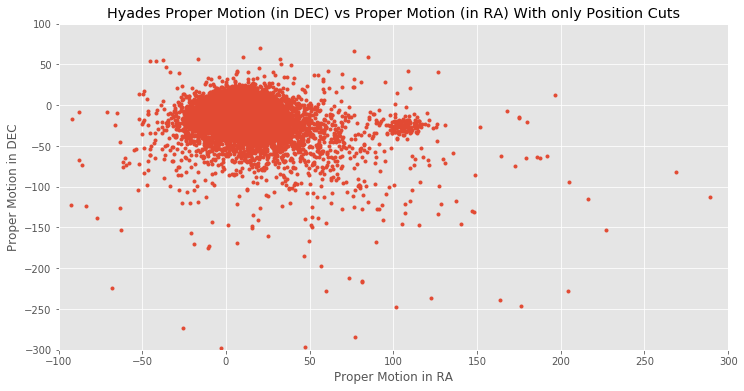

In [7]:
plt.plot(r['pmra'], r['pmdec'], '.')
plt.title('Hyades Proper Motion (in DEC) vs Proper Motion (in RA) With only Position Cuts')
plt.xlabel('Proper Motion in RA')
plt.ylabel('Proper Motion in DEC')
plt.xlim(-100, 300)
plt.ylim(-300, 100)
plt.show()

In [8]:
gaia = TapPlus(url="http://gea.esac.esa.int/tap-server/tap")
job = gaia.launch_job_async('''SELECT ALL source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,visibility_periods_used,phot_g_mean_mag,bp_rp,radial_velocity,radial_velocity_error,phot_variable_flag,teff_val,a_g_val, pmra, pmdec 
                                 FROM gaiadr2.gaia_source 
                                WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS',COORD1(EPOCH_PROP_POS(66.725,15.86667,0,104.9200,-28.0000,39.1000,2000,2015.5)),COORD2(EPOCH_PROP_POS(66.725,15.86667,0,104.9200,-28.0000,39.1000,2000,2015.5)),2.5))=1 
                                  AND (parallax_over_error>10 
                                  AND parallax>15.969 AND parallax<30.656)''', 
                            dump_to_file=True, output_file = 'hyades.vot')

r = job.get_results()

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


### As we can see from the plot below, after the position and parallax cuts it is clear that a cluster has been revealed.

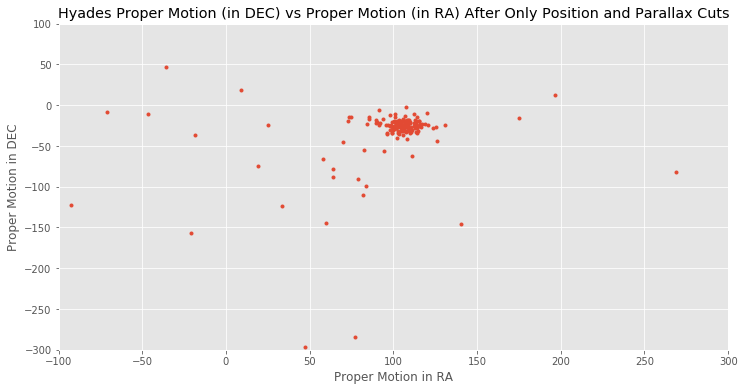

In [9]:
plt.plot(r['pmra'], r['pmdec'], '.')
plt.title('Hyades Proper Motion (in DEC) vs Proper Motion (in RA) After Only Position and Parallax Cuts')
plt.xlabel('Proper Motion in RA')
plt.ylabel('Proper Motion in DEC')
plt.xlim(-100, 300)
plt.ylim(-300, 100)
plt.show()

In [10]:
gaia = TapPlus(url="http://gea.esac.esa.int/tap-server/tap")
job = gaia.launch_job_async('''SELECT ALL source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,visibility_periods_used,phot_g_mean_mag,bp_rp,radial_velocity,radial_velocity_error,phot_variable_flag,teff_val,a_g_val, pmra, pmdec 
                                 FROM gaiadr2.gaia_source 
                                WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS',COORD1(EPOCH_PROP_POS(66.725,15.86667,0,104.9200,-28.0000,39.1000,2000,2015.5)),COORD2(EPOCH_PROP_POS(66.725,15.86667,0,104.9200,-28.0000,39.1000,2000,2015.5)),2.5))=1  
                                  AND  (parallax_over_error>10 AND parallax>15.969 AND parallax<30.656 
                                  AND sqrt(power(pmra,2) + power(pmdec,2))<111.906 AND sqrt(power(pmra,2) + power(pmdec,2))>101.227)''', 
                            dump_to_file=True, output_file = 'hyades.vot')

r = job.get_results()

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


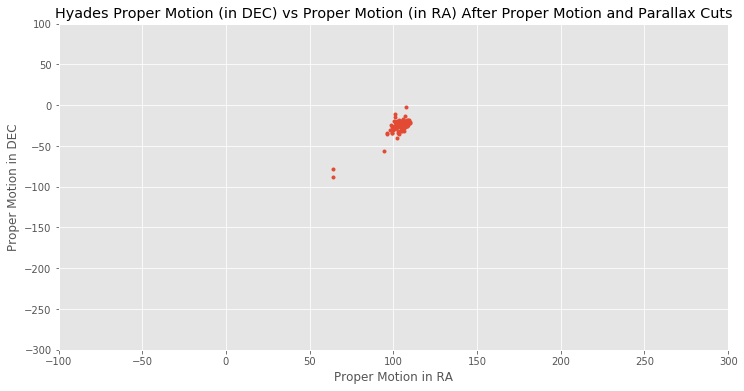

In [11]:
plt.plot(r['pmra'], r['pmdec'], '.')
plt.title('Hyades Proper Motion (in DEC) vs Proper Motion (in RA) After Proper Motion and Parallax Cuts')
plt.xlabel('Proper Motion in RA')
plt.ylabel('Proper Motion in DEC')
plt.xlim(-100, 300)
plt.ylim(-300, 100)
plt.show()

In [12]:
gaia = TapPlus(url="http://gea.esac.esa.int/tap-server/tap")
job = gaia.launch_job_async('''SELECT ALL source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,visibility_periods_used,phot_g_mean_mag,bp_rp,radial_velocity,radial_velocity_error,phot_variable_flag,teff_val,a_g_val, pmra, pmdec 
                                 FROM gaiadr2.gaia_source 
                                WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS',COORD1(EPOCH_PROP_POS(66.725,15.86667,0,104.9200,-28.0000,39.1000,2000,2015.5)),COORD2(EPOCH_PROP_POS(66.725,15.86667,0,104.9200,-28.0000,39.1000,2000,2015.5)),2.5))=1  
                                  AND  (visibility_periods_used>8 
                                  AND astrometric_excess_noise<1 
                                  AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2) 
                                  AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2) 
                                  AND parallax_over_error>10 AND phot_g_mean_flux_over_error>50 AND phot_rp_mean_flux_over_error>20 
                                  AND phot_bp_mean_flux_over_error>20 AND parallax>15.969 AND parallax<30.656 AND sqrt(power(pmra,2) + power(pmdec,2))<111.906 
                                  AND sqrt(power(pmra,2) + power(pmdec,2))>101.227)''', 
                            dump_to_file=True, output_file = 'hyades.vot')

r = job.get_results()

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


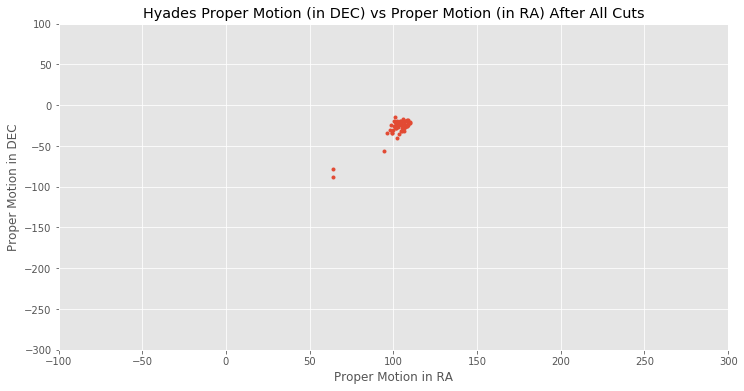

In [13]:
plt.plot(r['pmra'], r['pmdec'], '.')
plt.title('Hyades Proper Motion (in DEC) vs Proper Motion (in RA) After All Cuts')
plt.xlabel('Proper Motion in RA')
plt.ylabel('Proper Motion in DEC')
plt.xlim(-100, 300)
plt.ylim(-300, 100)
plt.show()

From the plot above, we can see how the cuts do a great job at isolating the Hyades cluster aside from a negligible three stray targets, with proper motion and parallax cuts doing the bulk of the work. Now below I am going to illustrate CMD differences of Hyades without any cuts (aside from position) and Hyades with proper motion cuts.

In [14]:
gaia = TapPlus(url="http://gea.esac.esa.int/tap-server/tap")
job = gaia.launch_job_async('''SELECT ALL source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,visibility_periods_used,phot_g_mean_mag,bp_rp,radial_velocity,radial_velocity_error,phot_variable_flag,teff_val,a_g_val, pmra, pmdec 
                                 FROM gaiadr2.gaia_source 
                                WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS',COORD1(EPOCH_PROP_POS(66.725,15.86667,0,104.9200,-28.0000,39.1000,2000,2015.5)),COORD2(EPOCH_PROP_POS(66.725,15.86667,0,104.9200,-28.0000,39.1000,2000,2015.5)),2.5))=1''', 
                            dump_to_file=True, output_file = 'hyades.vot')

r = job.get_results()

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


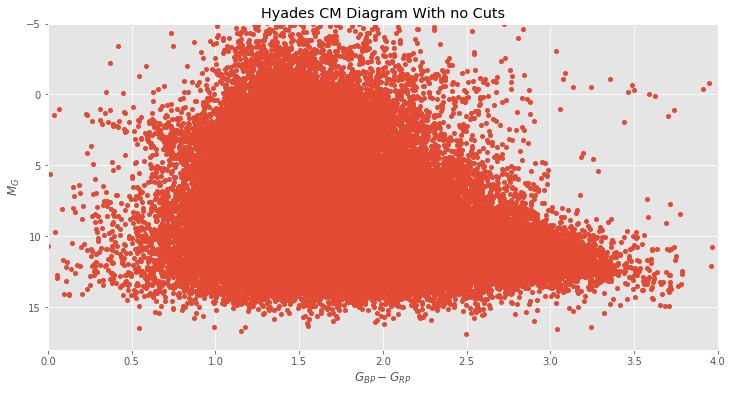

158758 stars


In [15]:
xcut  = r['bp_rp']
aparG = r['phot_g_mean_mag']
para  = abs(r['parallax']) / 1000
dist  = 1 / para #pc
absG  = aparG - 5 * np.log10(dist/10)

plt.plot(xcut, absG, '.', markersize = 8)
plt.title('Hyades CM Diagram With no Cuts')
plt.xlabel('$G_{BP} - G_{RP}$')
plt.ylabel('$M_G$')
plt.xlim(0, 4)
plt.ylim(18, -5)
plt.show()

print(len(aparG), 'stars')

In [16]:
gaia = TapPlus(url="http://gea.esac.esa.int/tap-server/tap")
job = gaia.launch_job_async('''SELECT ALL source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,visibility_periods_used,phot_g_mean_mag,bp_rp,radial_velocity,radial_velocity_error,phot_variable_flag,teff_val,a_g_val, pmra, pmdec 
                                 FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS',COORD1(EPOCH_PROP_POS(66.725,15.86667,0,104.9200,-28.0000,39.1000,2000,2015.5)),COORD2(EPOCH_PROP_POS(66.725,15.86667,0,104.9200,-28.0000,39.1000,2000,2015.5)),2.5))=1 
                                  AND sqrt(power(pmra,2) + power(pmdec,2))<111.906 
                                  AND sqrt(power(pmra,2) + power(pmdec,2))>101.227''', 
                            dump_to_file=True, output_file = 'hyades.vot')

r = job.get_results()

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


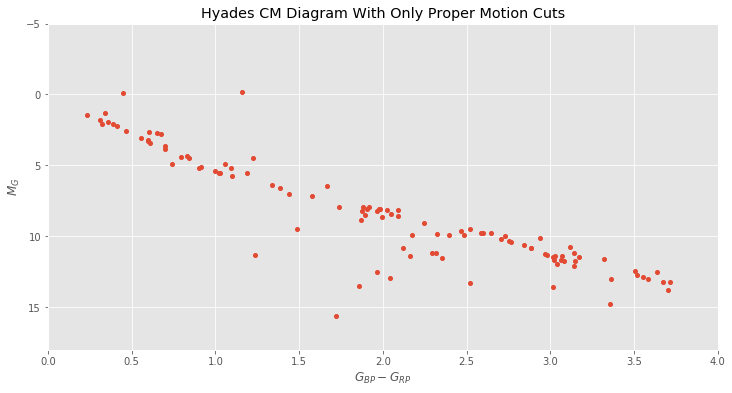

115 stars


In [17]:
xcut  = r['bp_rp']
aparG = r['phot_g_mean_mag']
para  = abs(r['parallax']) / 1000
dist  = 1 / para #pc
absG  = aparG - 5 * np.log10(dist/10)

plt.plot(xcut, absG, '.', markersize = 8)
plt.title('Hyades CM Diagram With Only Proper Motion Cuts')
plt.xlabel('$G_{BP} - G_{RP}$')
plt.ylabel('$M_G$')
plt.xlim(0, 4)
plt.ylim(18, -5)
plt.show()

print(len(aparG), 'stars')

### It is evident that with even just the proper motion cuts, nearly all the targets are cut out that are not in the Hyades cluster. The proper motion cuts do the most extreme job, out of any one single cut, at cleaning the CMD of targets outside the cluster.

Now below I have a final Hyades CMD with only astrometric cuts.

In [18]:
gaia = TapPlus(url="http://gea.esac.esa.int/tap-server/tap")
job = gaia.launch_job_async('''SELECT ALL source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,visibility_periods_used,phot_g_mean_mag,bp_rp,radial_velocity,radial_velocity_error,phot_variable_flag,teff_val,a_g_val, pmra, pmdec 
                                 FROM gaiadr2.gaia_source 
                                WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS',COORD1(EPOCH_PROP_POS(66.725,15.86667,0,104.9200,-28.0000,39.1000,2000,2015.5)),COORD2(EPOCH_PROP_POS(66.725,15.86667,0,104.9200,-28.0000,39.1000,2000,2015.5)),2.5))=1 AND parallax_over_error>10 AND parallax>15.969 AND parallax<30.656 
                                  AND astrometric_excess_noise<1 
                                  AND sqrt(power(pmra,2) + power(pmdec,2))<111.906 
                                  AND sqrt(power(pmra,2) + power(pmdec,2))>101.227''', 
                            dump_to_file=True, output_file = 'hyades.vot')

r = job.get_results()

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


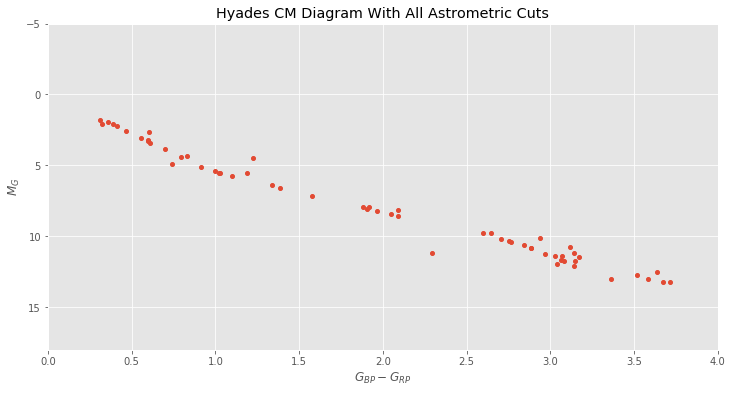

62 stars


In [19]:
xcut  = r['bp_rp']
aparG = r['phot_g_mean_mag']
para  = abs(r['parallax']) / 1000
dist  = 1 / para #pc
absG  = aparG - 5 * np.log10(dist/10)

plt.plot(xcut, absG, '.', markersize = 8)
plt.title('Hyades CM Diagram With All Astrometric Cuts')
plt.xlabel('$G_{BP} - G_{RP}$')
plt.ylabel('$M_G$')
plt.xlim(0, 4)
plt.ylim(18, -5)
plt.show()

print(len(aparG), 'stars')

So, without any quality cuts the CMD essentially looks like a blob-like triangle with about 160 thousand targets, but after all of my astrometric cuts, im left with a clean CMD that has a clearly visible main sequence that has only 62 targets.

### Now time to overplot some isochrones

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


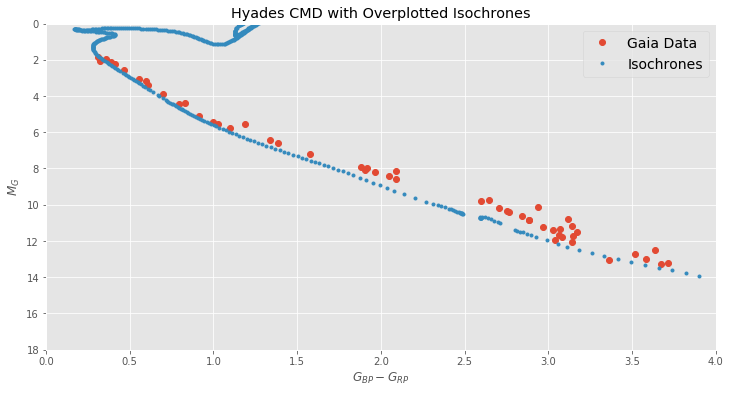

In [20]:
gaia = TapPlus(url="http://gea.esac.esa.int/tap-server/tap")
job = gaia.launch_job_async('''SELECT ALL source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,visibility_periods_used,phot_g_mean_mag,bp_rp,radial_velocity,radial_velocity_error,phot_variable_flag,teff_val,a_g_val, pmra, pmdec 
                                 FROM gaiadr2.gaia_source 
                                WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS',COORD1(EPOCH_PROP_POS(66.725,15.86667,0,104.9200,-28.0000,39.1000,2000,2015.5)),COORD2(EPOCH_PROP_POS(66.725,15.86667,0,104.9200,-28.0000,39.1000,2000,2015.5)),2.5))=1  
                                  AND  (visibility_periods_used>8 AND astrometric_excess_noise<1 
                                  AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2) 
                                  AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2) 
                                  AND parallax_over_error>10 
                                  AND phot_g_mean_flux_over_error>50 
                                  AND phot_rp_mean_flux_over_error>20 AND phot_bp_mean_flux_over_error>20 
                                  AND parallax>15.969 
                                  AND parallax<30.656 
                                  AND sqrt(power(pmra,2) + power(pmdec,2))<111.906 
                                  AND sqrt(power(pmra,2) + power(pmdec,2))>101.227)''', 
                            dump_to_file=True, output_file = 'hyades.vot')

r = job.get_results()

data = np.loadtxt('MIST_iso_hyades.iso.cmd', unpack=True)

xcut  = r['bp_rp']
aparG = r['phot_g_mean_mag']
para  = abs(r['parallax']) / 1000
dist  = 1 / para #pc
absG  = aparG - 5 * np.log10(dist/10)

plt.plot(xcut, absG, '.', markersize = 12, label = 'Gaia Data')
plt.plot(data[23,:] - data[24,:], data[22,:], '.', label = 'Isochrones', zorder = 2)
#plt.plot(data[23,5] - data[24,5], data[22,5], '.', markersize =20, label = 'Isochrones', zorder = 1)

plt.title('Hyades CMD with Overplotted Isochrones')
plt.xlabel('$G_{BP} - G_{RP}$')
plt.ylabel('$M_G$')
plt.xlim(0, 4)
plt.ylim(18, 0)
plt.legend(fontsize=14)
plt.show()


<b>Analysis</b>: All of these targets from the Hyades final cut are located in the main sequence, except the first few of the right most targets that are actually pre main sequence. The left most stars get close to the red giant branch, but nothing is there yet. This is due to the fact that Hyades is a relativly young cluster at about 625 million years of age. I would expect many of these targets to actually have properties of stellar multiplicity, but I cannot tell exclusivly from the CMD. Given that 44% of star systems in the stellar neighborhood are multiples (Raghavan et al. 2010) I wouldn't be suprised to find that a large potion of these targets are multi-stellar. This could also explain the slightly brighter pre-MS stars in the Gaia data compared to the isochrones. The Gaia target data has absolute Gaia magnitudes that are slightly larger than the isochrone data, especially in the beginning for the pre-MS stars, but the difference is marginal and may be due to the fact that the stellar aging model and data collection processes are not perfect, and I would not expect both data sets to match perfectly, but this fit looks very good to me.

## Data Retrieval  - M67

In [21]:
m67Dist = 827.8238 #pc
cutMin = 1000 / (m67Dist - 50)
cutMax = 1000 / (m67Dist + 50)
print(f'{cutMax} to {cutMin} mas')

1.139180778648289 to 1.2856382126646164 mas


In [22]:
gaia = TapPlus(url="http://gea.esac.esa.int/tap-server/tap")
job = gaia.launch_job_async('''SELECT ALL source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,phot_g_mean_mag,bp_rp,radial_velocity,radial_velocity_error,phot_variable_flag,teff_val,a_g_val, pmra, pmdec 
                                 FROM gaiadr2.gaia_source  
                                WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS',COORD1(EPOCH_PROP_POS(132.825,11.8,0,-6.5100,-4.5400,33.1000,2000,2015.5)),COORD2(EPOCH_PROP_POS(132.825,11.8,0,-6.5100,-4.5400,33.1000,2000,2015.5)),3))=1 
                                  AND  (visibility_periods_used>8 
                                  AND astrometric_excess_noise<1 
                                  AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2) 
                                  AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2) 
                                  AND parallax_over_error>10 
                                  AND phot_g_mean_flux_over_error>50 
                                  AND phot_rp_mean_flux_over_error>20 
                                  AND phot_bp_mean_flux_over_error>20 
                                  AND parallax>1.139 AND parallax<1.285 
                                  AND sqrt(power(pmra,2) + power(pmdec,2))<13.438 
                                  AND sqrt(power(pmra,2) + power(pmdec,2))>1.892)''', 
                            dump_to_file=True, output_file = 'm67.vot')

r = job.get_results()

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


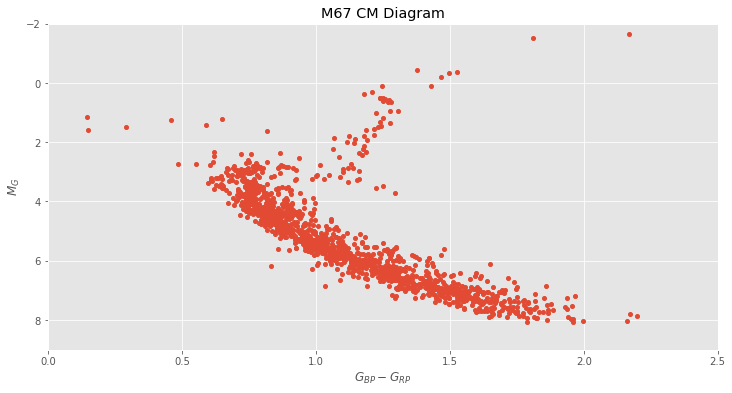

1435 stars


In [23]:
xcut  = r['bp_rp']
aparG = r['phot_g_mean_mag']
para  = abs(r['parallax']) / 1000
dist  = 1 / para #pc
absG  = aparG - 5 * np.log10(dist/10)

plt.plot(xcut, absG, '.', markersize = 8)
plt.title('M67 CM Diagram')
plt.xlabel('$G_{BP} - G_{RP}$')
plt.ylabel('$M_G$')
plt.xlim(0, 2.5)
plt.ylim(9, -2)
plt.show()

print(len(aparG), 'stars')

### Now time to overplot some isochrones

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


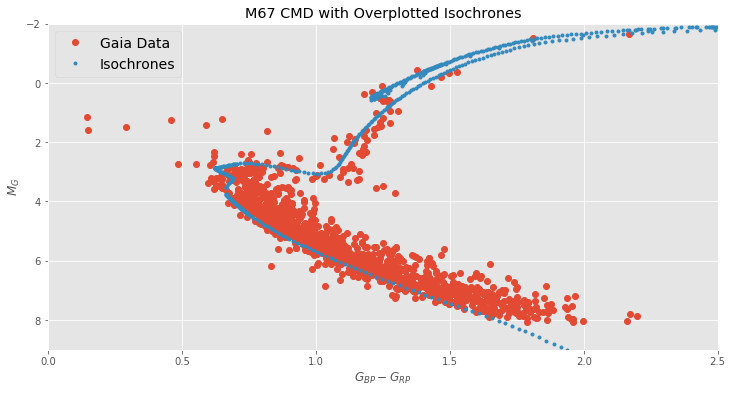

In [24]:
gaia = TapPlus(url="http://gea.esac.esa.int/tap-server/tap")
job = gaia.launch_job_async('''SELECT ALL source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,phot_g_mean_mag,bp_rp,radial_velocity,radial_velocity_error,phot_variable_flag,teff_val,a_g_val, pmra, pmdec 
                                 FROM gaiadr2.gaia_source  
                                WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS',COORD1(EPOCH_PROP_POS(132.825,11.8,0,-6.5100,-4.5400,33.1000,2000,2015.5)),COORD2(EPOCH_PROP_POS(132.825,11.8,0,-6.5100,-4.5400,33.1000,2000,2015.5)),3))=1 
                                  AND  (visibility_periods_used>8 
                                  AND astrometric_excess_noise<1 
                                  AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2) 
                                  AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2) 
                                  AND parallax_over_error>10 
                                  AND phot_g_mean_flux_over_error>50 
                                  AND phot_rp_mean_flux_over_error>20 
                                  AND phot_bp_mean_flux_over_error>20 
                                  AND parallax>1.139 AND parallax<1.285 
                                  AND sqrt(power(pmra,2) + power(pmdec,2))<13.438 
                                  AND sqrt(power(pmra,2) + power(pmdec,2))>1.892)''', 
                            dump_to_file=True, output_file = 'm67.vot')

r = job.get_results()

data = np.loadtxt('MIST_iso_m67.iso.cmd', unpack=True)

xcut  = r['bp_rp']
aparG = r['phot_g_mean_mag']
para  = abs(r['parallax']) / 1000
dist  = 1 / para #pc
absG  = aparG - 5 * np.log10(dist/10)

plt.plot(xcut, absG, '.', markersize = 12, label = 'Gaia Data')
plt.plot(data[23,:] - data[24,:], data[22,:], '.', label = 'Isochrones', zorder = 2)
#plt.plot(data[23,585] - data[24,585], data[22,585], '.', markersize =40, label = 'Isochrones', zorder = 100)

plt.title('M67 CMD with Overplotted Isochrones')
plt.xlabel('$G_{BP} - G_{RP}$')
plt.ylabel('$M_G$')
plt.xlim(0, 2.5)
plt.ylim(9, -2)
plt.legend(fontsize=14)
plt.show()


<b>Analysis</b>: Most of these targets in M67 are in the main sequence, with none in the pre main sequence. There are a quite few Gaia targets that are in the red giant branch, with a smaller number in the core helium burning sectiion, towards the top of the plot, along with a few targets in the early asymptotic giant branch. The top right most star is also in the late thermal pulse asymptotic giant branch, meaning it was born again and restarted. Again I can't really tell if any of these targets are binary systems etc. but I should be able to assume that a large portion of them are multi-stellar systems. There are slight discrepencies in the data, espeically in the beginning of the main-sequence section (like in the Hyades plot) which may be due to the cuts that I used or simply the metalicity or age I used being slightly off. The data fits better as the stars' lifetimes progress, with the isochrones sticking particularly well in that older branches in the CMD.

## Data Retrieval - NGC 6397

In [25]:
ngcDist = 2391.491 #pc
cutMin = 1000 / (ngcDist - 25)
cutMax = 1000 / (ngcDist + 25)
print(f'{cutMax} to {cutMin} mas')

0.41382318411283137 to 0.4225665764205315 mas


In [26]:
gaia = TapPlus(url="http://gea.esac.esa.int/tap-server/tap")
job = gaia.launch_job_async('''SELECT ALL source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,phot_g_mean_mag,bp_rp,radial_velocity,radial_velocity_error,phot_variable_flag,teff_val,a_g_val, pmra, pmdec 
                                 FROM gaiadr2.gaia_source  
                                WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS',COORD1(EPOCH_PROP_POS(265.175375,-53.674333,0,3.6900,-14.8800,18.9000,2000,2015.5)),COORD2(EPOCH_PROP_POS(265.175375,-53.674333,0,3.6900,-14.8800,18.9000,2000,2015.5)),2.5))=1 
                                  AND  (visibility_periods_used>8 
                                  AND astrometric_excess_noise<1 
                                  AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2) 
                                  AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2) 
                                  AND parallax_over_error>10 AND phot_g_mean_flux_over_error>50 
                                  AND phot_bp_mean_flux_over_error>20 
                                  AND phot_rp_mean_flux_over_error>20 
                                  AND parallax>0.413 
                                  AND parallax<0.422 
                                  AND sqrt(power(pmra,2) + power(pmdec,2))<7.536 
                                  AND sqrt(power(pmra,2) + power(pmdec,2))>1.907)''', 
                            dump_to_file=True, output_file = 'NGC6397.vot')

r = job.get_results()

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


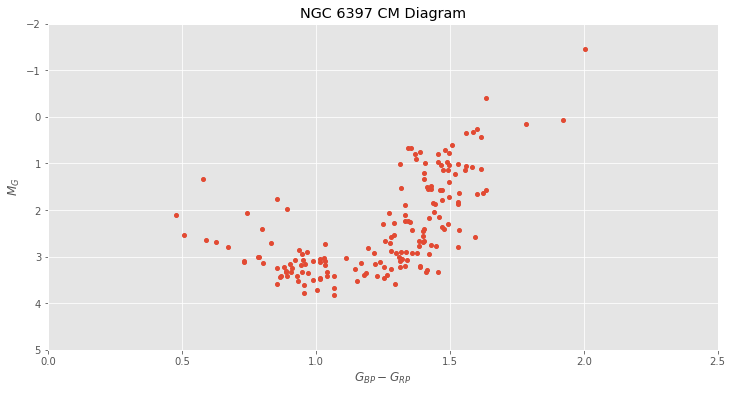

172 stars


In [27]:
xcut  = r['bp_rp']
aparG = r['phot_g_mean_mag']
para  = abs(r['parallax']) / 1000
dist  = 1 / para #pc
absG  = aparG - 5 * np.log10(dist/10)

plt.plot(xcut, absG, '.', markersize = 8)
plt.title('NGC 6397 CM Diagram')
plt.xlabel('$G_{BP} - G_{RP}$')
plt.ylabel('$M_G$')
plt.xlim(0, 2.5)
plt.ylim(5, -2)
plt.show()

print(len(aparG), 'stars')

### Now time to overplot some isochrones

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


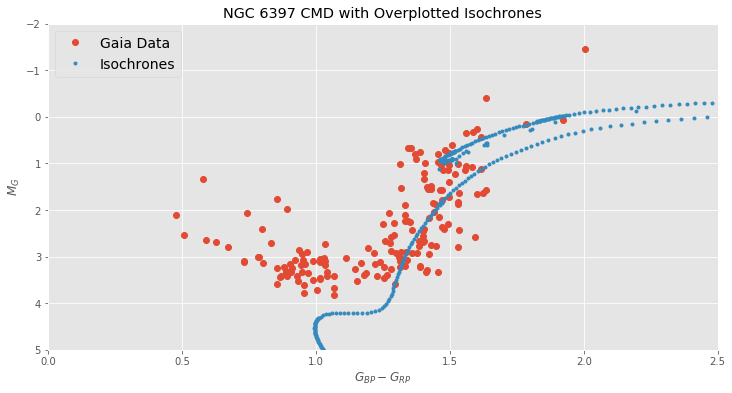

In [28]:
gaia = TapPlus(url="http://gea.esac.esa.int/tap-server/tap")
job = gaia.launch_job_async('''SELECT ALL source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,phot_g_mean_mag,bp_rp,radial_velocity,radial_velocity_error,phot_variable_flag,teff_val,a_g_val, pmra, pmdec 
                                 FROM gaiadr2.gaia_source  
                                WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS',COORD1(EPOCH_PROP_POS(265.175375,-53.674333,0,3.6900,-14.8800,18.9000,2000,2015.5)),COORD2(EPOCH_PROP_POS(265.175375,-53.674333,0,3.6900,-14.8800,18.9000,2000,2015.5)),2.5))=1 
                                  AND  (visibility_periods_used>8 AND astrometric_excess_noise<1 
                                  AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2) 
                                  AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2) 
                                  AND parallax_over_error>10 
                                  AND phot_g_mean_flux_over_error>50 
                                  AND phot_bp_mean_flux_over_error>20 
                                  AND phot_rp_mean_flux_over_error>20 
                                  AND parallax>0.413 AND parallax<0.422 
                                  AND sqrt(power(pmra,2) + power(pmdec,2))<7.536 
                                  AND sqrt(power(pmra,2) + power(pmdec,2))>1.907)''', 
                            dump_to_file=True, output_file = 'NGC6397.vot')

r = job.get_results()

data = np.loadtxt('MIST_iso_ngc.iso.cmd', unpack=True)

xcut  = r['bp_rp']
aparG = r['phot_g_mean_mag']
para  = abs(r['parallax']) / 1000
dist  = 1 / para #pc
absG  = aparG - 5 * np.log10(dist/10)

plt.plot(xcut, absG, '.', markersize = 12, label = 'Gaia Data')
plt.plot(data[23,:] - data[24,:], data[22,:], '.', label = 'Isochrones', zorder = 2)
#plt.plot(data[23,460] - data[24,460], data[22,460], '.', markersize =40, label = 'Isochrones', zorder = 100)

plt.title('NGC 6397 CMD with Overplotted Isochrones')
plt.xlabel('$G_{BP} - G_{RP}$')
plt.ylabel('$M_G$')
plt.xlim(0, 2.5)
plt.ylim(5, -2)
plt.legend(fontsize=14)
plt.show()

<b>Analysis</b>: None of the stars in this cluster are part of the pre-main sequence or main sequence, with the youngest tagets being in the red giant branch, consisting of most of the targets in this CMD. The targets at about the about 1.5 BP-RP and 1 MG point are at the core helium burning stage. There are a few targets along the top isochrone line at the top right that are in the early asymptotic giant branch. I cannot tell whether any of these systems are stellar multiples, but again, I can assume that a significant portion of them are binaries or tertiaries. This isochrone fit has the most discrepencies in the data out of all of the isochrone fits, especially in the beginning of the red giant branch where all of of the Gaia targets have smaller ablosute Gaia magnitudes than the isochrones. Increasing the metalicity in MIST helped the isochrones fit better, but the initial part of the red giant branch is still off by a decent amount.